In [1]:
"""Pipeline training script."""
import pandas as pd
pd.set_option('display.max_columns', None)

# DL for survival
import pycox
from pycox.models import DeepHitSingle, CoxPH
from pycox.evaluation import EvalSurv


from sklearn_pandas import DataFrameMapper
import torchtuples as tt
from pycox.evaluation import EvalSurv

import torch
import torchtuples as tt
import argparse
import joblib
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, train_test_split

%load_ext autoreload
%autoreload 2

from sklearn.pipeline import Pipeline
from derma.general.preprocessing.transformers import (TransformToNumeric, 
                                                      TransformToDatetime, 
                                                      ComputeAge,
                                                      TransformToObject,
                                                      KeepColumns,
                                                      ComputeAJCC,
                                                      LinkTumourPartToParent,
                                                      TransformCbRegression,
                                                      ConvertCategoriesToNaN,
                                                      ExponentialTransformer,
                                                      RenameLabValues,
                                                      CustomScaler,
                                                      CustomImputer)

from derma.general.preprocessing.encoders import (OrdinalEncoder,
                                                  GenderEncoder,
                                                  AbsentPresentEncoder,
                                                  LABEncoder,
                                                  CategoricalEncoder)


from derma.general.ingestion.data_loader_csv import SurvivalLoader
import config_os as settings_file

In [2]:
path = '/home/carlos.hernandez/datasets/csvs/data-surv_20220302.csv'
#X, target = SurvivalLoader('os').load_data(path)
X, _, time, event = SurvivalLoader('os').load_data(path)

target = [time, event]
X['duration'] = round(time)
X['event']    = event
X.dropna(subset=['duration'],inplace=True)
X = X[X['duration']>=0]

pipe = Pipeline(steps=[
    ('TransformToNumeric', TransformToNumeric(**settings_file.transform_to_numeric)), 
    ('TransformToDatetime', TransformToDatetime(**settings_file.transform_to_datetime)),
    ('TransformToObject', TransformToObject(**settings_file.transform_to_object)),
    ('ComputeAge', ComputeAge(**settings_file.compute_age)),
    ('tr_tm', LinkTumourPartToParent(**settings_file.link_tumour_part_to_parent)),
    ('tr_cb', TransformCbRegression(**settings_file.transform_cb_regression)),
    ('tr0', ConvertCategoriesToNaN(**settings_file.convert_categories_to_nan)),
    ('tr2', GenderEncoder(**settings_file.gender_encoder)),
    ('tr3', AbsentPresentEncoder(**settings_file.absent_present_encoder)),
    ("tr4", CategoricalEncoder(**settings_file.categorical_encoder)),
    ('tr7', LABEncoder(**settings_file.lab_encoder)),
    ('OrdinalEncoder', OrdinalEncoder(**settings_file.ordinal_encoder)),
    ('ComputeAJCC', ComputeAJCC(**settings_file.compute_ajcc)),
    ('tr5', ExponentialTransformer(**settings_file.exponential_transformer)),
    ('KeepColumns', KeepColumns(**settings_file.keep_cols)),
    ('CustomImputer', CustomImputer(strategy='mean')),
    ('CustomScaler', CustomScaler()),
    ('RenameLabValues', RenameLabValues(**settings_file.rename_lab_values)),
    ])

label = X[['duration', 'event']]

/home/carlos.hernandez/dl/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/carlos.hernandez/PhD/marato-derma/derma/general/ingestion/data_loader_csv.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['time'] = (target['date'] - target['cb_examined_at']


In [3]:
splits = []
labels = []

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, label,
                                            test_size=0.2, random_state=i)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                            test_size=0.5, random_state=i)
    
    X_train = pipe.fit_transform(X_train.copy(), y_train)
    X_val   = pipe.transform(X_val)
    X_test  = pipe.transform(X_test)
    
    splits.append([X_train, X_val, X_test])
    labels.append([y_train, y_val, y_test])

In [4]:
in_features = X_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
output_bias = False
batch_size = 256
epochs = 512
get_target = lambda df: (df['duration'].values, df['event'].values)
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
num_durations = 50
labtrans = DeepHitSingle.label_transform(num_durations)

--------------------
Split # 0:
--------------------
(2962, 68)
C_index for the split is -> 0.792
Brier score: 0.2807 +- 0.0
C-index test: 0.7917 +- 0.0


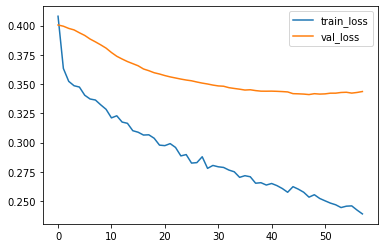

In [7]:
results = []
brier   = []
for i, (data, label) in enumerate(zip(splits, labels)):
    print(f'{20*"-"}\nSplit # {i}:\n{20*"-"}')
    print(data[0].shape)
    # Obtain labels
    y_train = labtrans.fit_transform(*get_target(label[0]))
    y_val = labtrans.transform(*get_target(label[1]))
    y_test  = get_target(label[2])
    
    # Transform data into numpy arrays
    leave = [(col, None) for col in data[0].columns]
    x_mapper = DataFrameMapper(leave)
    x_train = x_mapper.fit_transform(data[0]).astype('float32')
    x_val = x_mapper.transform(data[1]).astype('float32')
    x_test = x_mapper.transform(data[2]).astype('float32')
    
   # y_train = [(1, float(x[1])) if x[0] else (0, float(x[1])) for x in y_train]
   # y_train = np.array(y_train).astype(float)
   # y_val = [(1, float(x[1])) if x[0] else (0, float(x[1])) for x in y_val]
   # y_val = np.array(y_val).astype(float)
    val = x_val, y_val
    
    # Instantiate the model
    net = tt.practical.MLPVanilla(in_features, num_nodes, labtrans.out_features,
                                  batch_norm, dropout, output_bias=output_bias)
    model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)
    callbacks = [tt.callbacks.EarlyStopping()]
    model.optimizer.set_lr(0.001)
    # Train!
    log = model.fit(input=x_train, target=y_train, batch_size=batch_size,
                    epochs=epochs, callbacks=callbacks, verbose=False,
                        val_data=val, val_batch_size=batch_size)
    _ = log.plot()
    # See how good we trained!
    surv = model.interpolate(10).predict_surv_df(x_test)
    ev = EvalSurv(surv, y_test[0], y_test[1], censor_surv='km')
    c_index = ev.concordance_td('antolini')
    time_grid = np.linspace(y_test[0].min(), y_test[0].max(),50)
    ib_score = ev.integrated_brier_score(time_grid)
    
    brier.append(ib_score)
    results.append(c_index)
    print(f'C_index for the split is -> {round(c_index,3)}')
    break
print(f'Brier score: {round(np.mean(brier),4)} +- {np.std(brier)}')
print(f'C-index test: {round(np.mean(results),4)} +- {np.std(results)}')

## From here onwards its SurvTIME! (joke)

In [ ]:
y_train_fixed = (y_train[0], [True if 1 else False for x in y_train[1]])
unique_times = list(set(train_times))
unique_times.sort()

len(unique_times)